This notebook shows we how compute the Spread Skill diagrams 

In [1]:
import torch as to

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import xarray as xr

import tensorflow.keras as ke


from cbrain.imports import *

from cbrain.utils import *

from cbrain.cam_constants import *

from cbrain.data_generator import DataGenerator
import pandas as ps
import seaborn as sns

2024-01-31 14:59:03.948496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from cbrain.layers import *


In [3]:
import xarray as xr
import numpy as np
import math

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag

In [4]:

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX','PRECTt-dt','CLDLIQBP','CLDICEBP']
out_vars_CRM = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']

#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/real_geography_SP_vars_updt.csv')


QBC_std_surf=scale_array.QBCTEND_std.values[-1]

TBC_std=scale_array.TBCTEND_std.values[-1]
CLDLIQBCTEND_std=scale_array.CLDLIQBCTEND_std.values[-1]
CLDICEBCTEND_std=scale_array.CLDICEBCTEND_std.values[-1]


PRECT_std=scale_array.PRECT_std.values
PREC_CRM_SNOW_std=scale_array.PRECT_CRM_SNOW_std.values
PREC_CRM_std=scale_array.PRECT_CRM_std.values

NN2L_FLWDS_std=scale_array.NN2L_FLWDS_std.values
NN2L_DOWN_SW_std=scale_array.NN2L_DOWN_SW_std.values
NN2L_SOLL_std=scale_array.NN2L_SOLL_std.values
NN2L_SOLLD_std=scale_array.NN2L_SOLLD_std.values
NN2L_SOLS_std=scale_array.NN2L_SOLS_mean_std.values
NN2L_SOLSD_std=scale_array.NN2L_SOLSD_mean_std.values





# defining the scaling dict for the VAE training 

scale_dict_II = {
    'QBCTEND': 1/QBC_std_surf, 
    'TBCTEND': 1/TBC_std, 
    'CLDICEBCTEND': 1/CLDICEBCTEND_std, 
    'CLDLIQBCTEND': 1/CLDLIQBCTEND_std, 
    'NN2L_FLWDS':1/NN2L_FLWDS_std,
    'NN2L_DOWN_SW':1/NN2L_DOWN_SW_std,
    'NN2L_SOLL':1/NN2L_SOLL_std,
    'NN2L_SOLLD':1/NN2L_SOLLD_std,
    'NN2L_SOLS':1/NN2L_SOLS_std,
    'NN2L_SOLSD':1/NN2L_SOLSD_std,    
    'PRECT': 1/PRECT_std,
    'PREC_CRM': 1/PREC_CRM_std,
    'PREC_CRM_SNOW': 1/PREC_CRM_SNOW_std
}







from cbrain.data_generator import DataGenerator

test_xr=xr.open_dataset('/work/bd1179/from_Mistral/bd1179/b381624/CESM2_NN2_pelayout01_ens_07.cam.h1.2013-01-01-00000.nc')
hybi=test_xr.hybi
hyai=test_xr.hyai


PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


In [5]:
#load test data set
val_gen_II = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_CRM,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=False
)

# Load Individual Networks 

In [6]:
ANN_1_lin=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_CRM_lin_jit.pt')
ANN_2_lin=to.jit.load('real_geography/ANNs/ANN_2/ANN_2_CRM_lin_jit.pt')
ANN_3_lin=to.jit.load('real_geography/ANNs/ANN_3/ANN_3_CRM_lin_jit.pt')
ANN_4_lin=to.jit.load('real_geography/ANNs/ANN_4/ANN_4_CRM_lin_jit.pt')
ANN_5_lin=to.jit.load('real_geography/ANNs/ANN_5/ANN_5_CRM_lin_jit.pt')
ANN_6_lin=to.jit.load('real_geography/ANNs/ANN_6/ANN_6_CRM_lin_jit.pt')
ANN_7_lin=to.jit.load('real_geography/ANNs/ANN_7/ANN_7_CRM_lin_jit.pt')



In [7]:
VEncoder_1=to.jit.load('real_geography/VEDs/VED_1/VEncoder_1_torch_jit.pt')
VDecoder_1=to.jit.load('real_geography/VEDs/VED_1/VDecoder_1_torch_jit.pt')

VEncoder_2=to.jit.load('real_geography/VEDs/VED_2/VEncoder_2_torch_jit.pt')
VDecoder_2=to.jit.load('real_geography/VEDs/VED_2/VDecoder_2_torch_jit.pt')

VEncoder_3=to.jit.load('real_geography/VEDs/VED_3/VEncoder_3_torch_jit.pt')
VDecoder_3=to.jit.load('real_geography/VEDs/VED_3/VDecoder_3_torch_jit.pt')

VEncoder_4=to.jit.load('real_geography/VEDs/VED_4/VEncoder_4_torch_jit.pt')
VDecoder_4=to.jit.load('real_geography/VEDs/VED_4/VDecoder_4_torch_jit.pt')

VEncoder_5=to.jit.load('real_geography/VEDs/VED_5/VEncoder_5_torch_jit.pt')
VDecoder_5=to.jit.load('real_geography/VEDs/VED_5/VDecoder_5_torch_jit.pt')



VEncoder_7=to.jit.load('real_geography/VEDs/VED_7/VEncoder_7_torch_jit.pt')
VDecoder_7=to.jit.load('real_geography/VEDs/VED_7/VDecoder_7_torch_jit.pt')


In [8]:
ANN_1_lin_dr_01=to.jit.load('real_geography/ANNs/ANN_1/ANN_1_lin_dr_out_0_01_torch_jit.pt')


# Compute spread and skill for each ensemble 

In [12]:
def squared_dev_spread_ANN(ANN1,ANN2,ANN3,ANN4,ANN5,ANN6,ANN7,ensemble_size,data_set,time_steps,region):
    
    """
    compute spread skill for multi-ANN ensembles and ANN-dropout
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_liq_bc_pred_1=np.nan*np.zeros((region.size,data_set.output_idxs.size,7))
    

    cloud_liq_bc_true_1=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size))
        
    cloud_liq_bc_pred_2=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for i in tqdm(np.arange(time_steps)):
        rand_members=np.random.choice(7,ensemble_size,replace=False)
        
        cloud_liq_bc_true=to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])).detach().numpy()

            
        cloud_liq_bc_pred_1[:,:,0]=data_set.output_transform.inverse_transform(ANN1((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,1]=data_set.output_transform.inverse_transform(ANN2((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,2]=data_set.output_transform.inverse_transform(ANN3((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,3]=data_set.output_transform.inverse_transform(ANN4((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,4]=data_set.output_transform.inverse_transform(ANN5((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,5]=data_set.output_transform.inverse_transform(ANN6((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,6]=data_set.output_transform.inverse_transform(ANN7((to.from_numpy(data_set[rand_time_step[i]][0]))).detach().numpy())
        
        
        cloud_liq_bc_pred_2[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_pred_1[:,:,rand_members],(int(region.size),data_set.output_idxs.size,ensemble_size))
        cloud_liq_bc_true_1[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_true,(int(region.size),data_set.output_idxs.size))
    
    del cloud_liq_bc_pred_1,cloud_liq_bc_true
    cloud_liq_bc_pred_2_mean=np.mean(cloud_liq_bc_pred_2,2)
    
    cloud_member_dev=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for n in tqdm(np.arange(ensemble_size)):
    
        cloud_member_dev[:,:,n]=cloud_liq_bc_pred_2[:,:,n]-cloud_liq_bc_pred_2_mean
    
    squared_dev=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    spread=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    for k in tqdm(np.arange(squared_dev[:,1].size)):
        squared_dev[k]=(cloud_liq_bc_true_1[k]-cloud_liq_bc_pred_2_mean[k])**2
    
        spread[k]=np.sqrt(np.sum(cloud_member_dev[k]**2,1)/int(ensemble_size-1))
    del cloud_member_dev,cloud_liq_bc_pred_2_mean,cloud_liq_bc_pred_2
    return squared_dev,spread

In [13]:
#compute spread skill for \overline{ANN}

squared_dev_ANN_7_lin,spread_ANN_7_lin=squared_dev_spread_ANN(ANN_1_lin,ANN_2_lin,ANN_3_lin,
                                                              ANN_4_lin,ANN_5_lin,ANN_6_lin,
                                                      ANN_7_lin,7,val_gen_II,500,np.arange(int(144*96)))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [14]:
#compute spread skill for ANN-ens

squared_dev_ANN_5_lin,spread_ANN_5_lin=squared_dev_spread_ANN(ANN_1_lin,ANN_2_lin,ANN_3_lin,
                                                              ANN_4_lin,ANN_5_lin,ANN_6_lin,
                                                      ANN_7_lin,5,val_gen_II,500,np.arange(int(144*96)))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [17]:
#!mkdir spread_skill_data




In [19]:
#np.save('spread_skill_data/ANN_i_lin_spread',spread_ANN_7_lin)
#np.save('spread_skill_data/ANN_i_lin_squared_dev',squared_dev_ANN_7_lin)

In [20]:
#np.save('spread_skill_data/ANN_ensemble_lin_spread',spread_ANN_5_lin)
#np.save('spread_skill_data/ANN_ensemble_lin_squared_dev',squared_dev_ANN_5_lin)

In [22]:
#compute spread and skill for ANN-dropout 
squared_dev_ANN_1_dr_0_01,spread_ANN_1_dr_0_01=squared_dev_spread_ANN(ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,
                                                                      ANN_1_lin_dr_01,7,val_gen_II,500,np.arange(int(144*96)))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [23]:
#np.save('spread_skill_data/ANN_dropout_lin_spread',spread_ANN_1_dr_0_01)
#np.save('spread_skill_data/ANN_dropout_lin_squared_dev',squared_dev_ANN_1_dr_0_01)

In [15]:

def squared_dev_spread_VED(VEnc1,VEnc2,VEnc3,VEnc4,VEnc5,VEnc7,VDec1,VDec2,VDec3,VDec4,VDec5,VDec7,ensemble_size,data_set,time_steps,region):
    
    """
    compute spread skill for multi-VED ensemble
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    cloud_liq_bc_pred_1=np.nan*np.zeros((region.size,data_set.output_idxs.size,6))
    

    cloud_liq_bc_true_1=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size))
        
    cloud_liq_bc_pred_2=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for i in tqdm(np.arange(time_steps)):
        rand_members=np.random.choice(6,ensemble_size,replace=False)
        
        cloud_liq_bc_true=to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])).detach().numpy()

            
        cloud_liq_bc_pred_1[:,:,0]=data_set.output_transform.inverse_transform(VDec1(VEnc1((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,1]=data_set.output_transform.inverse_transform(VDec2(VEnc2((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,2]=data_set.output_transform.inverse_transform(VDec3(VEnc3((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,3]=data_set.output_transform.inverse_transform(VDec4(VEnc4((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,4]=data_set.output_transform.inverse_transform(VDec5(VEnc5((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        cloud_liq_bc_pred_1[:,:,5]=data_set.output_transform.inverse_transform(VDec7(VEnc7((to.from_numpy(data_set[rand_time_step[i]][0])))).detach().numpy())
        
        
        cloud_liq_bc_pred_2[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_pred_1[:,:,rand_members],(int(region.size),data_set.output_idxs.size,ensemble_size))
        cloud_liq_bc_true_1[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_true,(int(region.size),data_set.output_idxs.size))
    
    del cloud_liq_bc_pred_1,cloud_liq_bc_true
    cloud_liq_bc_pred_2_mean=np.mean(cloud_liq_bc_pred_2,2)
    
    cloud_member_dev=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for n in tqdm(np.arange(ensemble_size)):
    
        cloud_member_dev[:,:,n]=cloud_liq_bc_pred_2[:,:,n]-cloud_liq_bc_pred_2_mean
    
    squared_dev=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    spread=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    for k in tqdm(np.arange(squared_dev[:,1].size)):
        squared_dev[k]=(cloud_liq_bc_true_1[k]-cloud_liq_bc_pred_2_mean[k])**2
    
        spread[k]=np.sqrt(np.sum(cloud_member_dev[k]**2,1)/int(ensemble_size-1))
    del cloud_member_dev,cloud_liq_bc_pred_2_mean
    return squared_dev,spread

In [9]:
out_vars_VED = ['QBCTEND','TBCTEND','CLDLIQBCTEND','CLDICEBCTEND', 'PRECT','PREC_CRM_SNOW','PREC_CRM',
            'NN2L_FLWDS','NN2L_DOWN_SW','NN2L_SOLL','NN2L_SOLLD','NN2L_SOLS','NN2L_SOLSD']


In [10]:
val_gen_III = DataGenerator(
    data_fn = '../SPCESM_data/2015_test_7_consec_days_mem.nc',
    input_vars = in_vars,
    output_vars = out_vars_VED,
    norm_fn = '../SPCESM_data/2013_norm_7_consec_days_mem.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=int(96*144),
    shuffle=True
)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2764800 [00:00<?, ?it/s]

In [18]:
#compute spread and skill for \overline{VED}
squared_dev_VED_lin_6,spread_VED_lin_6=squared_dev_spread_VED(VEnc_1_CRM,VEnc_2_CRM,VEnc_3_CRM,VEnc_4_CRM,VEnc_5_CRM,VEnc_7_CRM,
                                                      VDec_1_CRM,VDec_2_CRM,VDec_3_CRM,VDec_4_CRM,VDec_5_CRM,VDec_7_CRM,
                                                      6,val_gen_II,500,np.arange(int(144*96)))

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [19]:
#np.save('spread_skill_data/VED_i_spread',spread_VED_lin_6)
#np.save('spread_skill_data/VED_i_squared_dev',squared_dev_VED_lin_6)

In [20]:

def squared_dev_spread_VED_internal_stand_norm(VDecoder,VEncoder,ensemble_size,data_set,time_steps,region,network_number
                                               ,noise_level):
    
    """
    compute spread skill for isotropic latent space manipulation
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    

    cloud_liq_bc_true_1=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size))
        
    cloud_liq_bc_pred_2=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    cloud_liq_bc_pred_1=np.nan*np.zeros((region.size,113,network_number))
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder_1.z_log_var.weight.size()[0]))

    
    
    print(st_norm_perturb.shape)
    for i in tqdm(np.arange(time_steps)):
    
            st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))
            
            rand_members=np.random.choice(7,ensemble_size,replace=False)
        
            cloud_liq_bc_true=to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])).detach().numpy()

            cloud_liq_bc_pred_1[:,:,0]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[0],alpha=noise_level).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,1]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[1],alpha=noise_level).float()).detach().numpy())

            cloud_liq_bc_pred_1[:,:,2]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[2],alpha=noise_level).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,3]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[3],alpha=noise_level).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,4]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[4],alpha=noise_level).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,5]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[5],alpha=noise_level).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,6]=data_set.output_transform.inverse_transform(VDecoder(to.add(VEncoder(to.from_numpy(data_set[rand_time_step[i]][0]).float()),st_norm_perturb[6],alpha=noise_level).float()).detach().numpy())
            
            cloud_liq_bc_pred_2[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_pred_1[:,:,rand_members],(int(region.size),data_set.output_idxs.size,ensemble_size))
            cloud_liq_bc_true_1[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_true,(int(region.size),data_set.output_idxs.size))
    
    del cloud_liq_bc_pred_1,cloud_liq_bc_true
    cloud_liq_bc_pred_2_mean=np.mean(cloud_liq_bc_pred_2,2)
    
    cloud_member_dev=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for n in tqdm(np.arange(ensemble_size)):
    
        cloud_member_dev[:,:,n]=cloud_liq_bc_pred_2[:,:,n]-cloud_liq_bc_pred_2_mean
    
    squared_dev=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    spread=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    for k in tqdm(np.arange(squared_dev[:,1].size)):
        squared_dev[k]=(cloud_liq_bc_true_1[k]-cloud_liq_bc_pred_2_mean[k])**2
    
        spread[k]=np.sqrt(np.sum(cloud_member_dev[k]**2,1)/int(ensemble_size-1))
    del cloud_member_dev,cloud_liq_bc_pred_2_mean
    return squared_dev,spread

In [ ]:
# compute spread skill for VED-draws 
squared_dev_VED1_0_0_7,spread_VED_VED1_0_0_7=squared_dev_spread_VED_internal_stand_norm(VDecoder_1,
                                                      VEncoder_1,
                                                      7,val_gen_III,500,np.arange(int(144*96)),7,0.0)

In [23]:
# compute spread skill for VED-static 
squared_dev_VED1_0_5_7,spread_VED_VED1_0_5_7=squared_dev_spread_VED_internal_stand_norm(VDecoder_1,
                                                      VEncoder_1,
                                                      7,val_gen_III,500,np.arange(int(144*96)),7,0.5)

(7, 13824, 13)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [24]:
#np.save('spread_skill_data/VED_draws_spread',spread_VED_VED1_0_0_7)
#np.save('spread_skill_data/VED_draws_squared_dev',squared_dev_VED1_0_0_7)
#np.save('spread_skill_data/VED_static_spread',spread_VED_VED1_0_5_7)
#np.save('spread_skill_data/VED_static_squared_dev',squared_dev_VED1_0_5_7)

In [26]:

def squared_dev_spread_VED_internal_alpha_norm(VDecoder,VEncoder,ensemble_size,data_set,time_steps,region,network_number
                                               ,noise_level):
    
    """
    compute spread skill for anisotropic latent space manipulation
    author: G.Behrens
    """
    
    rand_time_step=np.random.choice(data_set.n_batches,time_steps,replace=False)

    

    cloud_liq_bc_true_1=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size))
        
    cloud_liq_bc_pred_2=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    cloud_liq_bc_pred_1=np.nan*np.zeros((region.size,113,network_number))
    print(cloud_liq_bc_pred_1.shape)
    st_norm_perturb=np.nan*np.zeros((network_number,region.size,VEncoder_1.z_log_var.weight.size()[0]))

    
    
    print(st_norm_perturb.shape)
    for i in tqdm(np.arange(time_steps)):
    
            st_norm_perturb=to.from_numpy(np.random.standard_normal((st_norm_perturb.shape)))
            
            rand_members=np.random.choice(7,ensemble_size,replace=False)
        
            cloud_liq_bc_true=to.from_numpy(data_set.output_transform.inverse_transform(data_set[rand_time_step[i]][1])).detach().numpy()

            cloud_liq_bc_pred_1[:,:,0]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[0]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,1]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[1]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,2]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[2]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,3]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[3]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,4]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[4]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,5]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[5]).float()).detach().numpy())
            cloud_liq_bc_pred_1[:,:,6]=data_set.output_transform.inverse_transform(VDecoder((VEncoder(to.from_numpy(data_set[i][0]).float())+to.from_numpy(noise_level)*st_norm_perturb[6]).float()).detach().numpy())
        
            cloud_liq_bc_pred_2[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_pred_1[:,:,rand_members],(int(region.size),data_set.output_idxs.size,ensemble_size))
            cloud_liq_bc_true_1[i*region.size:(i+1)*region.size]=np.reshape(cloud_liq_bc_true,(int(region.size),data_set.output_idxs.size))
    
    del cloud_liq_bc_pred_1,cloud_liq_bc_true
    cloud_liq_bc_pred_2_mean=np.mean(cloud_liq_bc_pred_2,2)
    
    cloud_member_dev=np.nan*np.zeros((int(time_steps*region.size),data_set.output_idxs.size,ensemble_size))
    for n in tqdm(np.arange(ensemble_size)):
    
        cloud_member_dev[:,:,n]=cloud_liq_bc_pred_2[:,:,n]-cloud_liq_bc_pred_2_mean
    
    squared_dev=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    spread=np.nan*np.zeros((int(144*96*time_steps),data_set.output_idxs.size))
    for k in tqdm(np.arange(squared_dev[:,1].size)):
        squared_dev[k]=(cloud_liq_bc_true_1[k]-cloud_liq_bc_pred_2_mean[k])**2
    
        spread[k]=np.sqrt(np.sum(cloud_member_dev[k]**2,1)/int(ensemble_size-1))
    del cloud_member_dev,cloud_liq_bc_pred_2_mean
    return squared_dev,spread

In [28]:
#compute spread skill for VED-varying
squared_dev_VED1_7_alpha_1,spread_VED_VED1_7_alpha_1=squared_dev_spread_VED_internal_alpha_norm(VDecoder_1,
                                                      VEncoder_1,
                                                      7,val_gen_III,500,np.arange(int(144*96)),7,
                                                                                                np.load('alpha_arrs/alpha_1.npy'))

(13824, 113, 7)
(7, 13824, 13)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6912000 [00:00<?, ?it/s]

In [29]:
#np.save('spread_skill_data/VED_varying_spread',spread_VED_VED1_7_alpha_1)
#np.save('spread_skill_data/VED_varying_squared_dev',squared_dev_VED1_7_alpha_1)

# compute spread and skill histograms 

In [11]:
# load saved spread and skill files 

ANN_dropout_spread=np.load('spread_skill_data/ANN_dropout_lin_spread.npy')
ANN_dropout_squared_dev=np.load('spread_skill_data/ANN_dropout_lin_squared_dev.npy')

ANN_i_spread=np.load('spread_skill_data/ANN_i_lin_spread.npy')
ANN_i_squared_dev=np.load('spread_skill_data/ANN_i_lin_squared_dev.npy')

ANN_ens_spread=np.load('spread_skill_data/ANN_ensemble_lin_spread.npy')
ANN_ens_squared_dev=np.load('spread_skill_data/ANN_ensemble_lin_squared_dev.npy')

VED_i_spread=np.load('spread_skill_data/VED_i_spread.npy')
VED_i_squared_dev=np.load('spread_skill_data/VED_i_squared_dev.npy')

VED_draws_spread=np.load('spread_skill_data/VED_draws_spread.npy')
VED_draws_squared_dev=np.load('spread_skill_data/VED_draws_squared_dev.npy')

VED_static_spread=np.load('spread_skill_data/VED_static_spread.npy')
VED_static_squared_dev=np.load('spread_skill_data/VED_static_squared_dev.npy')

VED_varying_spread=np.load('spread_skill_data/VED_varying_spread.npy')
VED_varying_squared_dev=np.load('spread_skill_data/VED_varying_squared_dev.npy')



In [12]:
def hist_builder(spread,bin_s):
    """
    build spread histogram 
    
    author: G.Behrens
    """
    bins__=np.nan*np.zeros((spread[1,:].size,bin_s[:,1].size))
    for i in tqdm(np.arange(spread[1,:].size)):
        
        bins__[i]=np.histogram(spread[:,i],bins=np.squeeze(bin_s[:,i]))[1]
    
    return bins__

In [13]:
# compute bin edges for VED-static 

bins__=np.nan*np.zeros((np.arange(0,100.1,2.5).size,VED_static_spread[1,:].size))

for i in tqdm(np.arange((np.arange(0,100.1,2.5).size))):
    
    bins__[i]=np.percentile(VED_static_spread,np.arange(0,100.1,2.5)[i],axis=0)

  0%|          | 0/41 [00:00<?, ?it/s]

In [21]:
bins__.shape

(41, 113)

In [14]:
# compute spread histogram of VED-static
bin_7=hist_builder(VED_static_spread,bins__)

  0%|          | 0/113 [00:00<?, ?it/s]

In [15]:
def hist_locator(data_set,bin_edges):
    
    """
    get IDs within a certain spread bin
    """
    data_set_digit=np.digitize(data_set,bin_edges)
    bin_locator=np.nan*np.ones((bin_edges.size,data_set_digit.size))
    for i in np.arange(1,bin_edges.size):
        bin_locator[i-1,0:np.where((data_set>=bin_edges[i-1])&(data_set<bin_edges[i]))[0].size]=np.where((data_set>=bin_edges[i-1])&(data_set<bin_edges[i]))[0]
        #print((data_set>=bin_edges[i-1]).size)
        #print((data_set<bin_edges[i]).size)
        #print(np.where((data_set>=bin_edges[i-1])&(data_set<bin_edges[i]))[0].size)
    #print(bin_locator)
    return bin_locator

In [16]:
# these levels are surface \dot{q}, surface \dot{T}, \dot{q_cl} in the planetary boundary layer and  \dot{q_ci} in the upper troposphere  
special_levels=np.array([25,51,int(22+52),int(15+78)])

In [20]:
spread_VED_VED1_7_alpha_1.shape

NameError: name 'spread_VED_VED1_7_alpha_1' is not defined

In [21]:
bin_7[special_levels]

array([[1.23828243e-10, 1.98229296e-09, 3.06667740e-09, 4.26058645e-09,
        5.60872277e-09, 7.10903122e-09, 8.72436863e-09, 1.04580669e-08,
        1.23373101e-08, 1.43943254e-08, 1.66758415e-08, 1.92442337e-08,
        2.21776728e-08, 2.55674908e-08, 2.95252283e-08, 3.41270227e-08,
        3.94470087e-08, 4.53800988e-08, 5.16973671e-08, 5.82605525e-08,
        6.49389552e-08, 7.16303062e-08, 7.82498015e-08, 8.48591751e-08,
        9.14090496e-08, 9.79771115e-08, 1.04510339e-07, 1.11072775e-07,
        1.17674877e-07, 1.24465425e-07, 1.31443361e-07, 1.38679408e-07,
        1.46357819e-07, 1.54550330e-07, 1.63408706e-07, 1.73359611e-07,
        1.84809000e-07, 1.98749555e-07, 2.17050068e-07, 2.46233565e-07,
        6.26409990e-07],
       [2.62831882e-07, 3.58699964e-06, 5.59262804e-06, 7.83053345e-06,
        1.00154670e-05, 1.19931955e-05, 1.38205083e-05, 1.55746224e-05,
        1.73246072e-05, 1.90769004e-05, 2.08747045e-05, 2.27262483e-05,
        2.46561298e-05, 2.66624797e-05,

In [17]:
def compute_SSREL(squared_dev,spread,bins__):
    
    """
    compute spread averages, conditional skill averages and spread-skill reliability within a certain spread bin
    
    """
    
    
    SSREL=np.nan*np.zeros((bins__[:,1].size))
    

    SSREL_part=np.nan*np.zeros((bins__[1,:].size,bins__[:,1].size))
    spread_mean=np.zeros((bins__[1,:].size,bins__[:,1].size))
    RMSE_mean=np.zeros((bins__[1,:].size,bins__[:,1].size))
    #print(RMSE_mean.shape)
    
    for j in tqdm(np.arange(SSREL.size)):
        bin_IDs=hist_locator(spread[:,j],bins__[j])
        #print(bin_IDs)
        for i in np.arange(0,bin_IDs[:,1].size):
            RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
            spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)
            #print(spread[np.isfinite(bin_IDs[i]),j].size)
            SSREL_part[i,j]=spread[np.isfinite(bin_IDs[i]),j].size/squared_dev.size*np.abs(RMSE_mean[i,j]-spread_mean[i,j])
            #print(SSREL_part.shape)
        SSREL=np.nansum(SSREL_part,0)
    SSREL_norm=SSREL/np.nanmean(RMSE_mean,0)
    return SSREL,SSREL_norm,RMSE_mean,spread_mean

In [18]:
#compute spread-skill for VED-static

SSREL_VED_static,SSREL_norm_VED_static,RMSE_VED_static_mean,spread_mean_VED_static=compute_SSREL(VED_static_squared_dev[:,special_levels],
                                                                                                 VED_static_spread[:,special_levels],
                                                                                                 bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [19]:
#compute spread-skill for VED-varying


SSREL_VED_varying,SSREL_norm_VED_varying,RMSE_VED_varying_mean,spread_mean_VED_varying=compute_SSREL(VED_varying_squared_dev[:,special_levels],
                                                                                                 VED_varying_spread[:,special_levels],
                                                                                                     bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [20]:
#compute spread-skill for VED-draws


SSREL_VED_draws,SSREL_norm_VED_draws,RMSE_VED_draws_mean,spread_mean_VED_draws=compute_SSREL(VED_draws_squared_dev[:,special_levels],
                                                                                                 VED_draws_spread[:,special_levels],
                                                                                             bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [21]:
#compute spread-skill for \overline{VED}

SSREL_VED_i,SSREL_norm_VED_i,RMSE_VED_i_mean,spread_mean_VED_i=compute_SSREL(VED_i_squared_dev[:,special_levels],
                                                                                                 VED_i_spread[:,special_levels],
                                                                                             bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [22]:
#compute spread-skill for \overline{ANN} / \overline{DNN}

SSREL_ANN_i,SSREL_norm_ANN_i,RMSE_ANN_i_mean,spread_mean_ANN_i=compute_SSREL(ANN_i_squared_dev[:,special_levels],
                                                                                                 ANN_i_spread[:,special_levels],
                                                                                             bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [23]:
#compute spread-skill for ANN-ens / DNN-ens


SSREL_ANN_ens,SSREL_norm_ANN_ens,RMSE_ANN_ens_mean,spread_mean_ANN_ens=compute_SSREL(ANN_ens_squared_dev[:,special_levels],
                                                                                                 ANN_ens_spread[:,special_levels],
                                                                                             bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


In [24]:
#compute spread-skill for ANN-dropout / DNN-dropout


SSREL_ANN_dropout,SSREL_norm_ANN_dropout,RMSE_ANN_dropout_mean,spread_mean_ANN_dropout=compute_SSREL(ANN_dropout_squared_dev[:,special_levels],
                                                                                                 ANN_dropout_spread[:,special_levels],
                                                                                             bin_7[special_levels])

  0%|          | 0/4 [00:00<?, ?it/s]

/tmp/ipykernel_240665/1713645683.py:21: RuntimeWarning: Mean of empty slice
  RMSE_mean[i,j]=np.sqrt(np.nanmean(squared_dev[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j]))
/tmp/ipykernel_240665/1713645683.py:22: RuntimeWarning: Mean of empty slice
  spread_mean[i,j]=np.nanmean(spread[bin_IDs[i][np.isfinite(bin_IDs[i])].astype(int),j],0)


# plot spread skill histograms 

Text(0.5, 1.0, 'd) dq$_{cld \\ ice}$/dt 288hPa [$\\frac{g}{kg \\times h}$]')

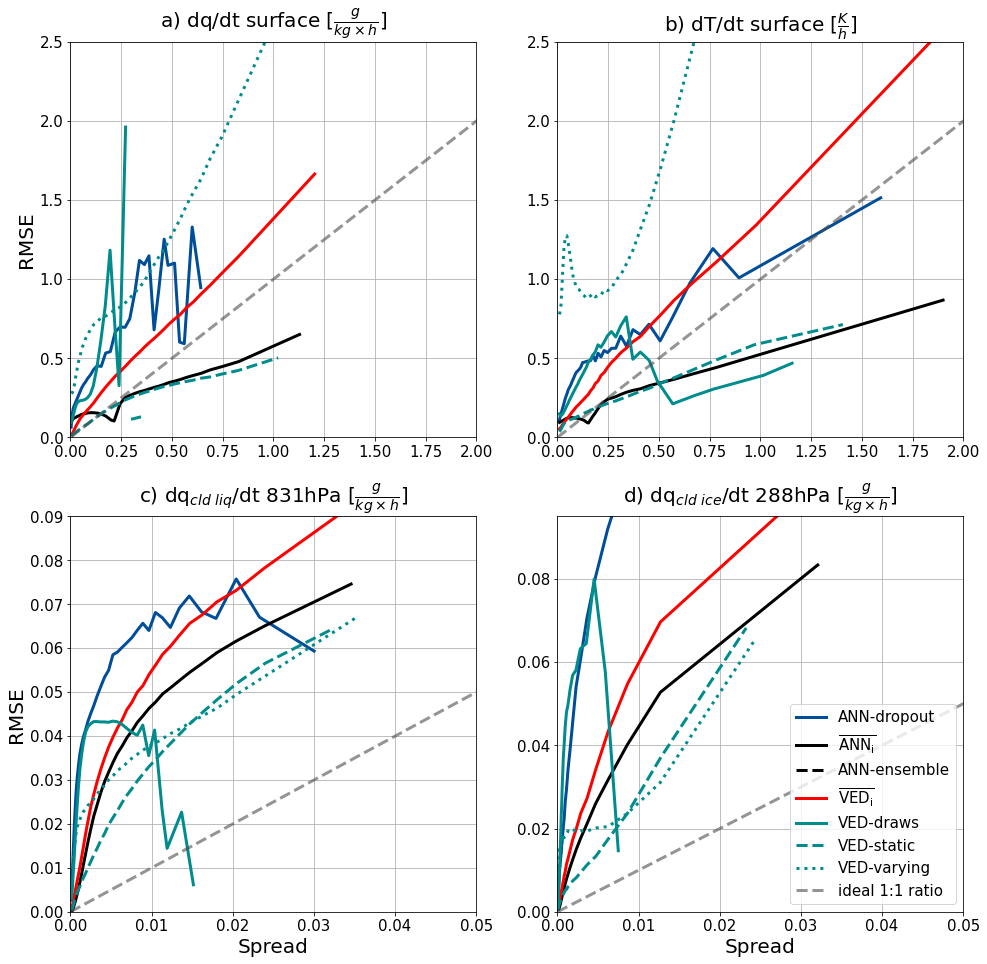

In [108]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_draws[:,0],3600*1000*RMSE_VED_draws_mean[:,0],linewidth=3,color=[0,0.55,0.55],label=r'VED draws')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) dq/dt surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_draws[:,1],3600*RMSE_VED_draws_mean[:,1],linewidth=3,color=[0,0.55,0.55],label=r'VED draws')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) dT/dt surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_draws[:,2],3600*1000*RMSE_VED_draws_mean[:,2],linewidth=3,color=[0,0.55,0.55],label=r'VED draws')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.09)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) dq$_{cld \ liq}$/dt 831hPa [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')
plt.plot(3600*1000*spread_mean_VED_draws[:,3],3600*1000*RMSE_VED_draws_mean[:,3],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.095)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) dq$_{cld \ ice}$/dt 288hPa [$\frac{g}{kg \times h}$]',fontsize=20)


Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

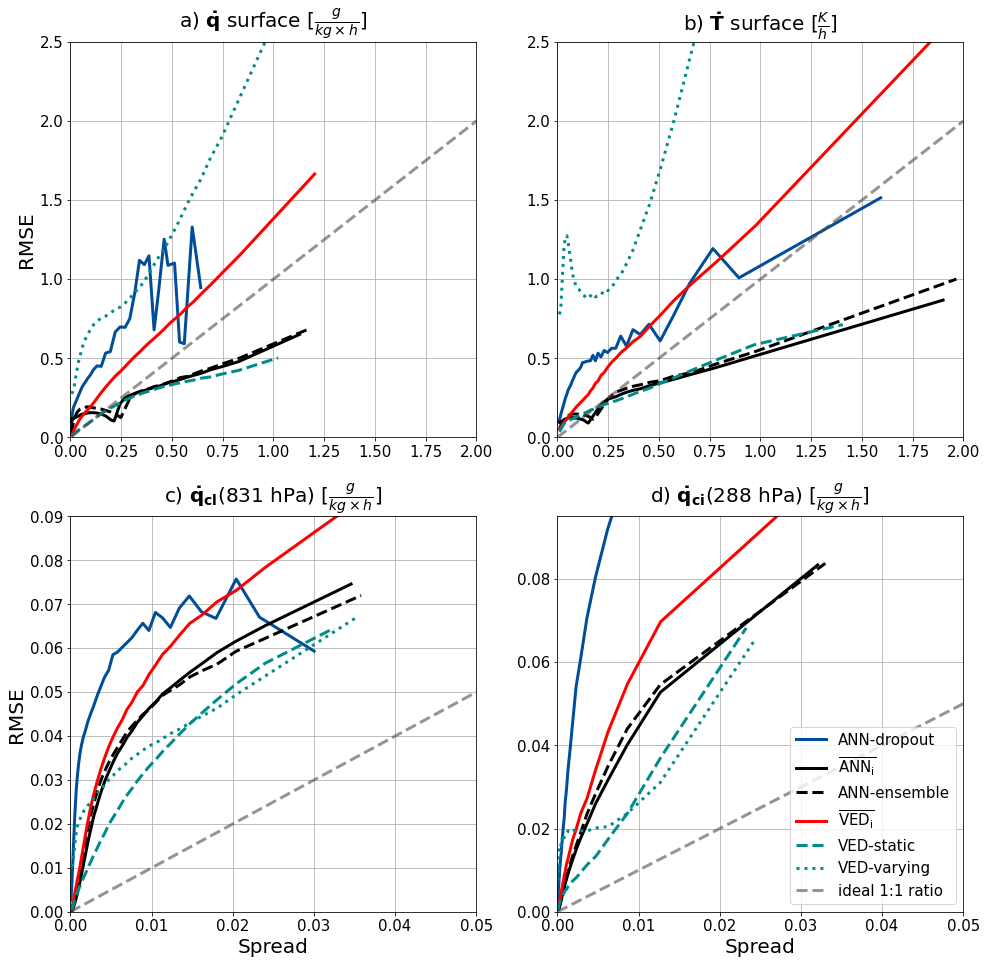

In [33]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.09)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.095)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

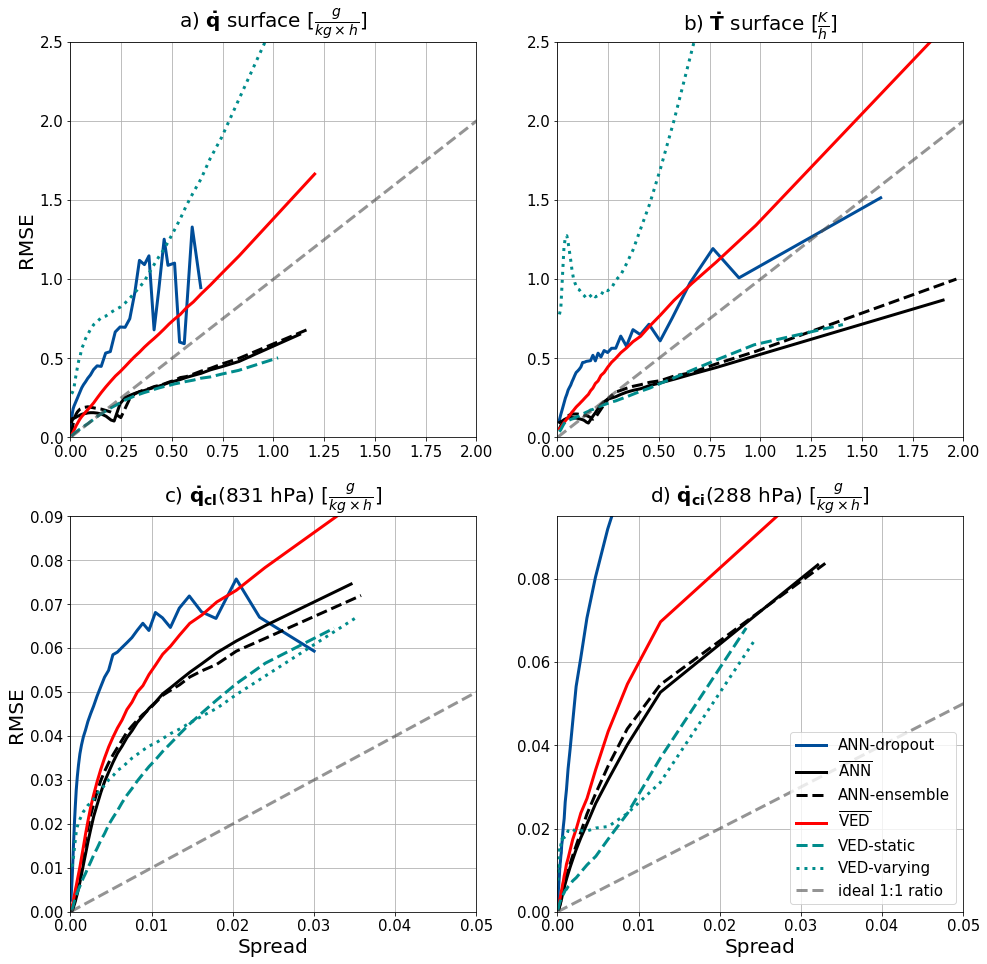

In [87]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.09)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.095)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

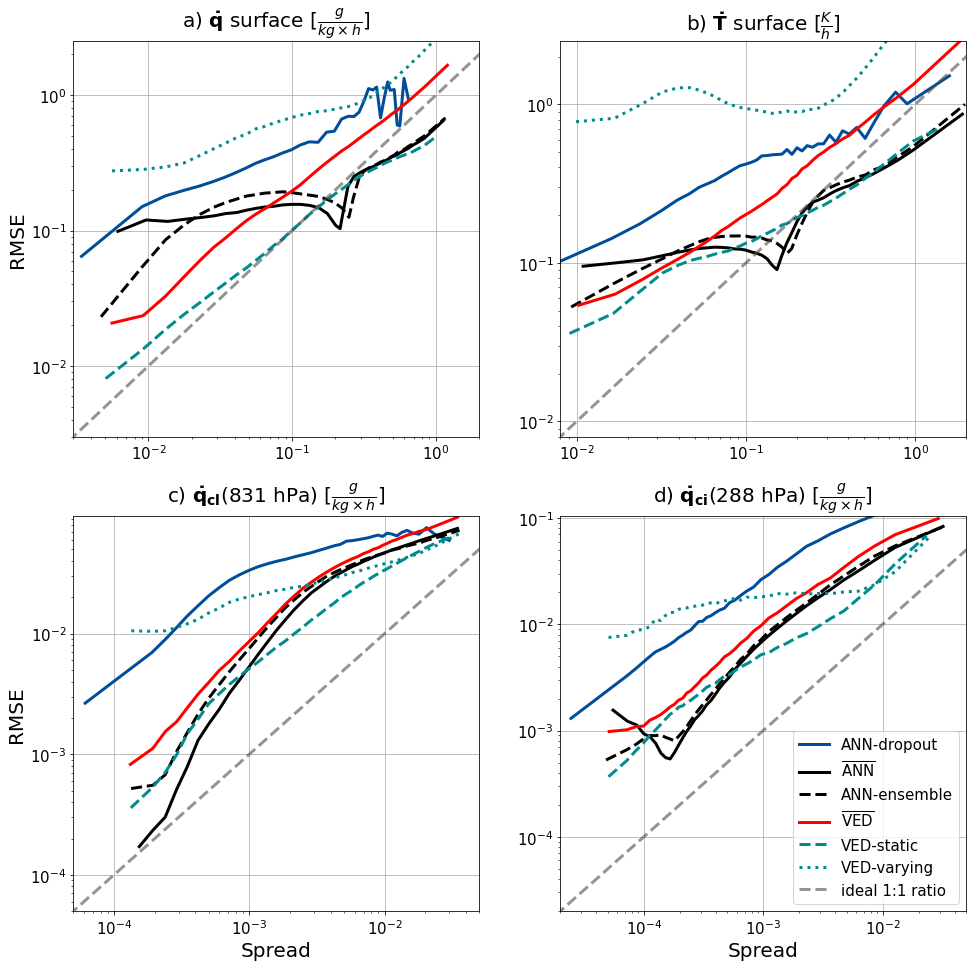

In [26]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(3E-3,2)
plt.ylim(3E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(8E-3,2)
plt.ylim(8E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(5E-5,0.05)
plt.ylim(5E-5,0.095)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(2E-5,0.05)
plt.ylim(2E-5,0.105)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

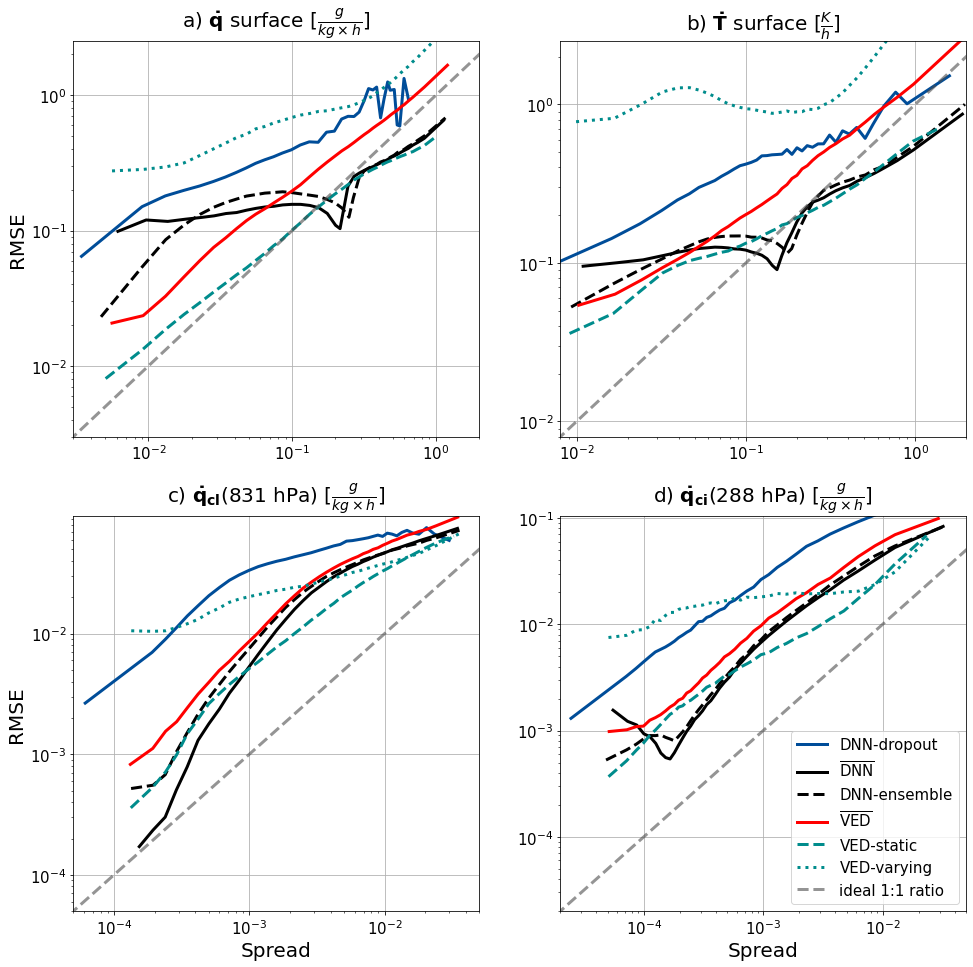

In [25]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(3E-3,2)
plt.ylim(3E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(8E-3,2)
plt.ylim(8E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(5E-5,0.05)
plt.ylim(5E-5,0.095)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'DNN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{DNN}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'DNN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(2E-5,0.05)
plt.ylim(2E-5,0.105)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

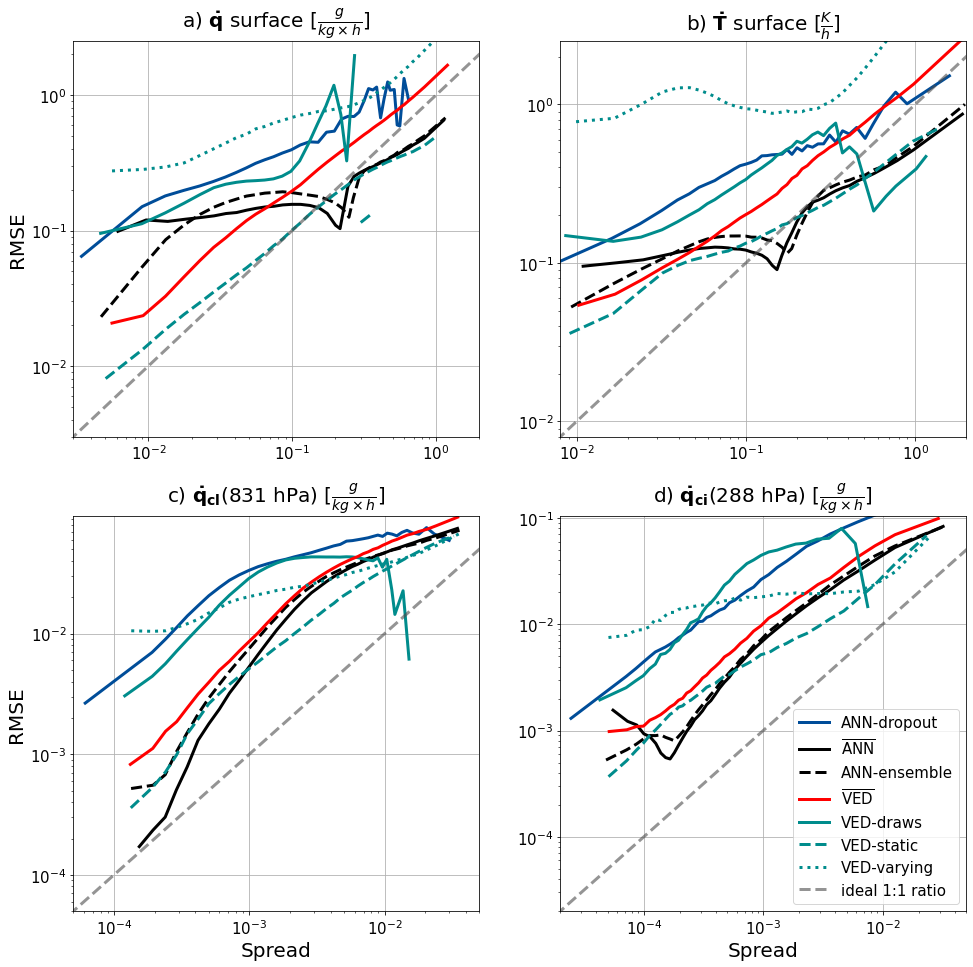

In [37]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_draws[:,0],3600*1000*RMSE_VED_draws_mean[:,0],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(3E-3,2)
plt.ylim(3E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_draws[:,1],3600*RMSE_VED_draws_mean[:,1],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(8E-3,2)
plt.ylim(8E-3,2.5)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)

plt.subplot(2,2,3)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_draws[:,2],3600*1000*RMSE_VED_draws_mean[:,2],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(5E-5,0.05)
plt.ylim(5E-5,0.095)
plt.xscale('log')
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')
plt.plot(3600*1000*spread_mean_VED_draws[:,3],3600*1000*RMSE_VED_draws_mean[:,3],linewidth=3,color=[0,0.55,0.55],label=r'VED-draws')

plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(2E-5,0.05)
plt.ylim(2E-5,0.105)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'b) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

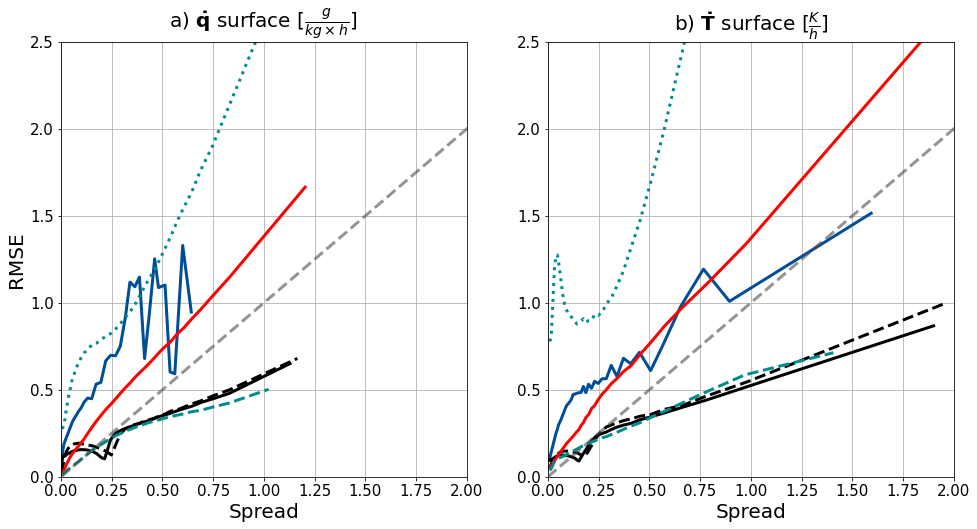

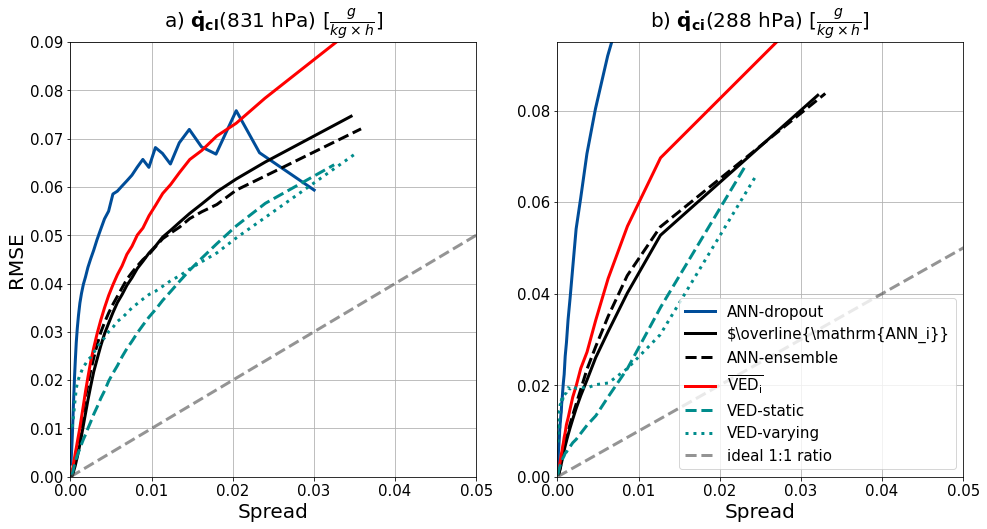

In [86]:
plt.figure(3,(16,8))
plt.subplot(1,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,0],3600*1000*RMSE_ANN_dropout_mean[:,0],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,0],3600*1000*RMSE_ANN_i_mean[:,0],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,0],3600*1000*RMSE_ANN_ens_mean[:,0],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,0],3600*1000*RMSE_VED_i_mean[:,0],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,0],3600*1000*RMSE_VED_static_mean[:,0],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,0],3600*1000*RMSE_VED_varying_mean[:,0],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)

plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(1,2,2)
plt.plot(3600*spread_mean_ANN_dropout[:,1],3600*RMSE_ANN_dropout_mean[:,1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*spread_mean_ANN_i[:,1],3600*RMSE_ANN_i_mean[:,1],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*spread_mean_ANN_ens[:,1],3600*RMSE_ANN_ens_mean[:,1],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*spread_mean_VED_i[:,1],3600*RMSE_VED_i_mean[:,1],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*spread_mean_VED_static[:,1],3600*RMSE_VED_static_mean[:,1],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*spread_mean_VED_varying[:,1],3600*RMSE_VED_varying_mean[:,1],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
plt.ylim(0,2.5)
plt.xlabel(r'Spread',fontsize=20)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)


plt.figure(4,(16,8))


plt.subplot(1,2,1)
plt.plot(3600*1000*spread_mean_ANN_dropout[:,2],3600*1000*RMSE_ANN_dropout_mean[:,2],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,2],3600*1000*RMSE_ANN_i_mean[:,2],linewidth=3,color='k',label=r'ANN_i')
plt.plot(3600*1000*spread_mean_ANN_ens[:,2],3600*1000*RMSE_ANN_ens_mean[:,2],'--',linewidth=3,color='k',label=r'ANN_ens')
plt.plot(3600*1000*spread_mean_VED_i[:,2],3600*1000*RMSE_VED_i_mean[:,2],linewidth=3,color='r',label=r'VED_i')
plt.plot(3600*1000*spread_mean_VED_static[:,2],3600*1000*RMSE_VED_static_mean[:,2],'--',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.2$ 7 draws')
plt.plot(3600*1000*spread_mean_VED_varying[:,2],3600*1000*RMSE_VED_varying_mean[:,2],':',linewidth=3,color=[0,0.55,0.55],label=r'VED 1 $\alpha=0.5$ 7 draws')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.09)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.ylabel(r'RMSE',fontsize=20)

plt.title(r'a) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(1,2,2)

plt.plot(3600*1000*spread_mean_ANN_dropout[:,3],3600*1000*RMSE_ANN_dropout_mean[:,3],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.plot(3600*1000*spread_mean_ANN_i[:,3],3600*1000*RMSE_ANN_i_mean[:,3],linewidth=3,color='k'
         ,label=r'$\overline{\mathrm{ANN_i}}')
plt.plot(3600*1000*spread_mean_ANN_ens[:,3],3600*1000*RMSE_ANN_ens_mean[:,3],'--',linewidth=3
         ,color='k',label=r'ANN-ensemble')
plt.plot(3600*1000*spread_mean_VED_i[:,3],3600*1000*RMSE_VED_i_mean[:,3],linewidth=3,color='r'
         ,label=r'$\overline{\mathrm{VED_i}}$')
plt.plot(3600*1000*spread_mean_VED_static[:,3],3600*1000*RMSE_VED_static_mean[:,3],'--',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-static')
plt.plot(3600*1000*spread_mean_VED_varying[:,3],3600*1000*RMSE_VED_varying_mean[:,3],':',linewidth=3,color=[0,0.55,0.55],
         label=r'VED-varying')


plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.05)
plt.ylim(0,0.095)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'b) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


In [43]:
bin_7[special_levels][0]

array([1.23828243e-10, 1.98229296e-09, 3.06667740e-09, 4.26058645e-09,
       5.60872277e-09, 7.10903122e-09, 8.72436863e-09, 1.04580669e-08,
       1.23373101e-08, 1.43943254e-08, 1.66758415e-08, 1.92442337e-08,
       2.21776728e-08, 2.55674908e-08, 2.95252283e-08, 3.41270227e-08,
       3.94470087e-08, 4.53800988e-08, 5.16973671e-08, 5.82605525e-08,
       6.49389552e-08, 7.16303062e-08, 7.82498015e-08, 8.48591751e-08,
       9.14090496e-08, 9.79771115e-08, 1.04510339e-07, 1.11072775e-07,
       1.17674877e-07, 1.24465425e-07, 1.31443361e-07, 1.38679408e-07,
       1.46357819e-07, 1.54550330e-07, 1.63408706e-07, 1.73359611e-07,
       1.84809000e-07, 1.98749555e-07, 2.17050068e-07, 2.46233565e-07,
       6.26409990e-07])

In [56]:
np.histogram(3600*1000*ANN_dropout_spread,bins=3600*1000*bin_7[special_levels][0])

(array([82397712,  4912191,  2636931,  1582587,   981205,   585167,
          348928,   218697,   144948,   103149,    81893,    75368,
           85731,   120963,   192025,   319663,   498659,   711649,
          936311,  1145867,  1318444,  1449136,  1564167,  1637292,
         1712144,  1750525,  1794173,  1818555,  1881902,  1929782,
         1990338,  2094334,  2201787,  2341597,  2572557,  2885752,
         3404836,  4277445,  6399034, 52069652]),
 array([4.45781674e-04, 7.13625465e-03, 1.10400386e-02, 1.53381112e-02,
        2.01914020e-02, 2.55925124e-02, 3.14077271e-02, 3.76490408e-02,
        4.44143164e-02, 5.18195716e-02, 6.00330295e-02, 6.92792414e-02,
        7.98396222e-02, 9.20429667e-02, 1.06290822e-01, 1.22857282e-01,
        1.42009231e-01, 1.63368356e-01, 1.86110522e-01, 2.09737989e-01,
        2.33780239e-01, 2.57869102e-01, 2.81699285e-01, 3.05493030e-01,
        3.29072579e-01, 3.52717601e-01, 3.76237222e-01, 3.99861991e-01,
        4.23629558e-01, 4.48075531e-01

# Related Spread histograms 

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

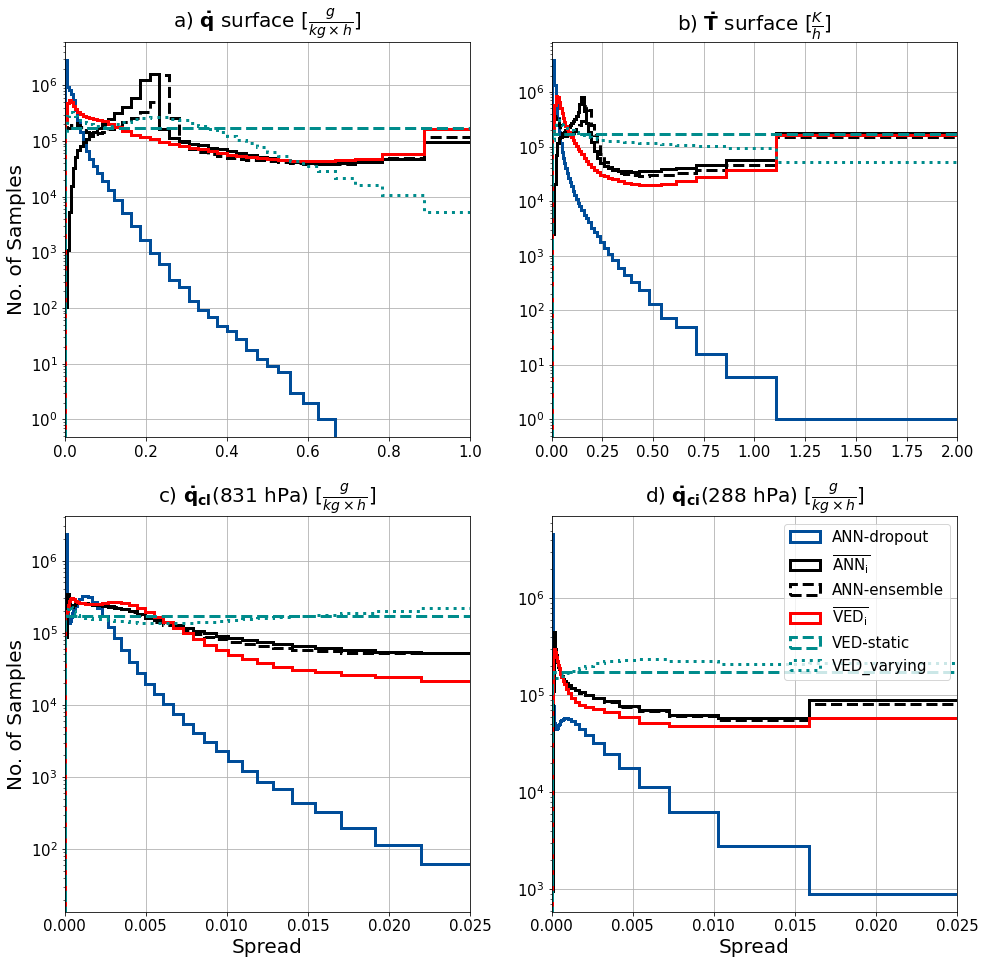

In [89]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,1)
#plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.ylabel('No. of Samples',fontsize=20)
#plt.xlabel(r'Spread',fontsize=20)

#plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.hist(3600*ANN_dropout_spread[:,[special_levels[1]]], histtype='step',
         bins=3600*bin_7[special_levels][1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*ANN_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*ANN_ens_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*VED_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step'
         ,linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*VED_static_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*VED_varying_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
#plt.ylim(0,2.5)
#plt.xlabel(r'Spread',fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)




plt.subplot(2,2,3)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')

plt.ylabel('No. of Samples',fontsize=20)

plt.grid(True)
plt.xlim(0,0.025)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],
         histtype='step',linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED_varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.025)
#plt.ylim(0,0.095)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

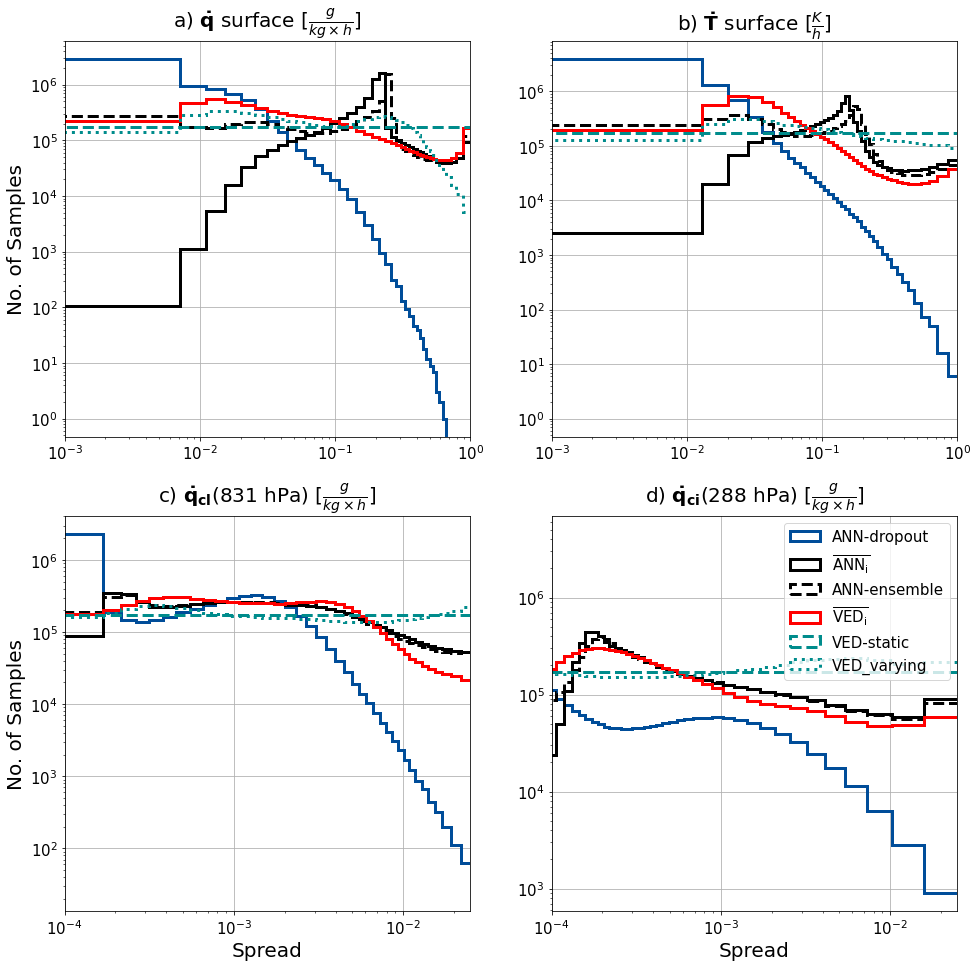

In [42]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(1E-3,1)
plt.xscale('log')
#plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.ylabel('No. of Samples',fontsize=20)
#plt.xlabel(r'Spread',fontsize=20)

#plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.hist(3600*ANN_dropout_spread[:,[special_levels[1]]], histtype='step',
         bins=3600*bin_7[special_levels][1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*ANN_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*ANN_ens_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*VED_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step'
         ,linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*VED_static_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*VED_varying_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(1E-3,1)
plt.xscale('log')
#plt.ylim(0,2.5)
#plt.xlabel(r'Spread',fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)




plt.subplot(2,2,3)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')

plt.ylabel('No. of Samples',fontsize=20)

plt.grid(True)
plt.xlim(1E-4,0.025)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],
         histtype='step',linewidth=3,color='k',label=r'$\overline{\mathrm{ANN_i}}$')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linewidth=3,color='r',label=r'$\overline{\mathrm{VED_i}}$')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED_varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(1E-4,0.025)
plt.xscale('log')
#plt.ylim(0,0.095)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)

Text(0.5, 1.0, 'd) $\\mathbf{\\dot{q}_{ci}}$(288 hPa) [$\\frac{g}{kg \\times h}$]')

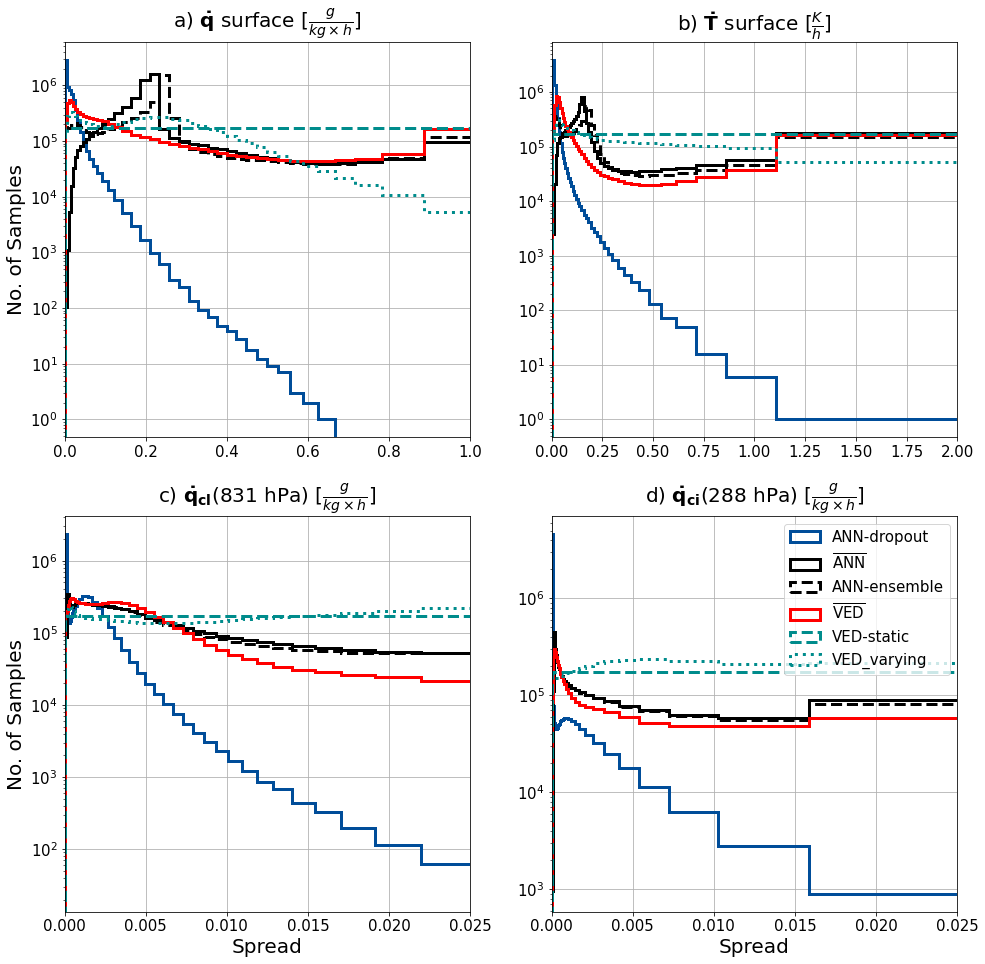

In [90]:
plt.figure(3,(16,16))
plt.subplot(2,2,1)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[0]]],bins=3600*1000*bin_7[special_levels][0],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,1)
#plt.ylim(0,2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale('log')
plt.ylabel('No. of Samples',fontsize=20)
#plt.xlabel(r'Spread',fontsize=20)

#plt.ylabel(r'RMSE',fontsize=20)
plt.title(r'a) $\mathbf{\dot{q}}$ surface [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,2)
plt.hist(3600*ANN_dropout_spread[:,[special_levels[1]]], histtype='step',
         bins=3600*bin_7[special_levels][1],linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*ANN_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*ANN_ens_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*VED_i_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step'
         ,linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*VED_static_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*VED_varying_spread[:,[special_levels[1]]],bins=3600*bin_7[special_levels][1], histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,2)
#plt.ylim(0,2.5)
#plt.xlabel(r'Spread',fontsize=20)
plt.yscale('log')

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title(r'b) $\mathbf{\dot{T}}$ surface [$\frac{K}{h}$]',fontsize=20)




plt.subplot(2,2,3)
plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],
         histtype='step',linewidth=3,color='k',label=r'ANN_i')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN_ens')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linewidth=3,color='r',label=r'VED_i')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[2]]],bins=3600*1000*bin_7[special_levels][2],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED-varying')

plt.ylabel('No. of Samples',fontsize=20)

plt.grid(True)
plt.xlim(0,0.025)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Spread',fontsize=20)

plt.title(r'c) $\mathbf{\dot{q}_{cl}}$(831 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)


plt.subplot(2,2,4)

plt.hist(3600*1000*ANN_dropout_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3]
         ,histtype='step',linewidth=3
         ,color=[0,0.3,0.6],label=r'ANN-dropout')
plt.hist(3600*1000*ANN_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],
         histtype='step',linewidth=3,color='k',label=r'$\overline{\mathrm{ANN}}$')
plt.hist(3600*1000*ANN_ens_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color='k',label=r'ANN-ensemble')
plt.hist(3600*1000*VED_i_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linewidth=3,color='r',label=r'$\overline{\mathrm{VED}}$')
plt.hist(3600*1000*VED_static_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle='--',linewidth=3,color=[0,0.55,0.55],label=r'VED-static')
plt.hist(3600*1000*VED_varying_spread[:,[special_levels[3]]],bins=3600*1000*bin_7[special_levels][3],histtype='step',
         linestyle=':',linewidth=3,color=[0,0.55,0.55],label=r'VED_varying')


#plt.plot(np.arange(0,5,0.1),np.arange(0,5,0.1),'--',linewidth=3,color=[0.3,0.3,0.3,0.6],label= 'ideal 1:1 ratio')
plt.grid(True)
plt.xlim(0,0.025)
#plt.ylim(0,0.095)
plt.yscale('log')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel(r'Spread',fontsize=20)
plt.legend(fontsize=15)
plt.title(r'd) $\mathbf{\dot{q}_{ci}}$(288 hPa) [$\frac{g}{kg \times h}$]',fontsize=20)